In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics, cross_validation

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run enviroment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_-1

dataset_path = "data_msg_type/"
X_path = dataset_path + "semantic_sim.txt"
y_path = dataset_path + "semantic_label_index.txt"

X = load_X(X_path)
y = load_y(y_path)

# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=33)#add random state here...
print("Dataset separated.\n")

Separating data into 80% training set & 20% test set...
Dataset separated.



# param config

In [5]:
class Config(object):
    """
    A class to store parameters, the input should be feature mat of training and testing
    Note: it would be more interesting to use a HyperOpt search space:
    https://github.com/hyperopt/hyperopt
    """
    def __init__(self, X_train, X_test):
        # Input data
        self.train_count = len(X_train)  # 80,000 training series
        self.test_data_count = len(X_test)  # 20,000 testing series
        self.n_steps = len(X_train[0])  # 140 time_steps (features) per series

        # Training
        self.learning_rate = 0.0001
        self.lambda_loss_amount = 0.005
        self.training_epochs = self.train_count * 100
        self.batch_size = 1000
        self.total_batches = self.train_count // self.batch_size
        self.display_iter = 20000  # To show test set accuracy during training

        # LSTM structure
        # Features count is of 1 (1*3D sensors features over time)
        self.n_inputs = len(X_train[0][0]) # 1
        self.n_hidden = 128  # nb of neurons inside the neural network
        self.n_classes = 14  # Final output classes
        
        self.W = {
            'hidden': tf.Variable(tf.random_normal([self.n_inputs, self.n_hidden])),
            'output': tf.Variable(tf.random_normal([self.n_hidden, self.n_classes]))}
        self.biases = {
            'hidden': tf.Variable(tf.random_normal([self.n_hidden], mean=1.0)),
            'output': tf.Variable(tf.random_normal([self.n_classes]))}
        
config = Config(X_train, X_test)
print("test features shape, labels shape, each features mean, each features standard deviation")
print(X_test.shape, y_test.shape,
      np.mean(X_test), np.std(X_test))
print("the dataset is properly normalised, as expected.")

test features shape, labels shape, each features mean, each features standard deviation
((20000, 140, 1), (20000, 1), 0.22152378, 0.18706892)
the dataset is properly normalised, as expected.


# lstm network

In [6]:
def LSTM_Network(_X, config):
    """
    Two LSTM cells are stacked which adds deepness to the neural network.
    Args:
        _X: ndarray feature matrix, shape: [batch_size, time_steps, n_inputs]
        return: matrix  output shape [batch_size,n_classes]
    """
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, config.n_inputs])
    # new shape: (n_steps*batch_size, n_input)

    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, config.W['hidden']) + config.biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    print(_X.shape)
    _X = tf.split(_X, config.n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)sr

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, 
                  state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, 
                  state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], 
                  state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    print(lstm_last_output.shape)

    # Linear activation
    return tf.matmul(lstm_last_output, config.W['output']) + config.biases['output']

# build the neural network

In [7]:
x = tf.placeholder(tf.float32, shape=[None, config.n_steps, config.n_inputs])
y = tf.placeholder(tf.float32, shape=[None, config.n_classes])

pred_y = LSTM_Network(x, config)

# Loss,optimizer,evaluation
l2 = config.lambda_loss_amount * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    
# Softmax loss and L2
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred_y)) + l2
optimizer = tf.train.AdamOptimizer(
    learning_rate=config.learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

(?, 128)
(?, 128)


# one hot

In [8]:
def one_hot(y_):
    """
    Function to encode output labels from number indexes.
    E.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    """
    y_ = y_.reshape(len(y_))
    #n_values = int(np.max(y_)) + 1
    n_values = config.n_classes
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

# batch extract

In [9]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

# train the neural network

In [17]:
# tracking training performance
test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


# Launch the graph
# Note that log_device_placement can be turned ON but will cause console spam with RNNs.
sess = tf.InteractiveSession(config=sess_config)
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * config.batch_size <= config.training_epochs:
    batch_xs = extract_batch_size(X_train, step, config.batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, config.batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run([optimizer, cost, accuracy],
        feed_dict={x: batch_xs, y: batch_ys})

    train_losses.append(loss)
    train_accuracies.append(acc)  
    
    batch_xt = extract_batch_size(X_test, step, config.batch_size)
    batch_yt = one_hot(extract_batch_size(y_test, step, config.batch_size))
    
    # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
    test_predict, test_loss, accs = sess.run([pred_y, cost, accuracy], 
                                    feed_dict={x: batch_xt, y: batch_yt})

    test_losses.append(test_loss)
    test_accuracies.append(accs)
    test_predictions.append(test_predict)

    # Evaluate network only at some steps for faster training: 
    if (step*config.batch_size % config.display_iter == 0) or (step == 1) \
        or (step * config.batch_size > config.training_epochs):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training epochs #" + str(step*config.batch_size) + \
          ":   Batch Loss = " + "{:.6f}".format(loss) + \
          ", Accuracy = {}".format(acc))

        print("Performance on test set: " + "Batch Loss = {}".format(test_loss) + \
            ", Accuracy = {}".format(accs))
    step += 1

print("Optimization Finished!")

Training epochs #1000:   Batch Loss = 10.259197, Accuracy = 0.141000002623
Performance on test set: Batch Loss = 9.61208248138, Accuracy = 0.62600004673
Training epochs #2000:   Batch Loss = 9.575900, Accuracy = 0.64200001955
Performance on test set: Batch Loss = 9.41447067261, Accuracy = 0.639999985695
Training epochs #4000:   Batch Loss = 9.345415, Accuracy = 0.633000016212
Performance on test set: Batch Loss = 9.34604644775, Accuracy = 0.620999991894
Training epochs #6000:   Batch Loss = 9.322807, Accuracy = 0.604000031948
Performance on test set: Batch Loss = 9.02978801727, Accuracy = 0.646999955177
Training epochs #8000:   Batch Loss = 9.141677, Accuracy = 0.59500002861
Performance on test set: Batch Loss = 9.07680034637, Accuracy = 0.614000022411
Training epochs #10000:   Batch Loss = 9.031722, Accuracy = 0.633999943733
Performance on test set: Batch Loss = 8.95463466644, Accuracy = 0.631000041962
Training epochs #12000:   Batch Loss = 8.926466, Accuracy = 0.618000030518
Performa

Training epochs #108000:   Batch Loss = 8.161005, Accuracy = 0.759999990463
Performance on test set: Batch Loss = 8.1341085434, Accuracy = 0.753000020981
Training epochs #110000:   Batch Loss = 8.107346, Accuracy = 0.763000011444
Performance on test set: Batch Loss = 8.05840396881, Accuracy = 0.77999997139
Training epochs #112000:   Batch Loss = 8.089188, Accuracy = 0.763999938965
Performance on test set: Batch Loss = 8.09570503235, Accuracy = 0.766000032425
Training epochs #114000:   Batch Loss = 8.061478, Accuracy = 0.78200006485
Performance on test set: Batch Loss = 8.06059837341, Accuracy = 0.7650000453
Training epochs #116000:   Batch Loss = 8.028507, Accuracy = 0.779000043869
Performance on test set: Batch Loss = 7.98470926285, Accuracy = 0.800000011921
Training epochs #118000:   Batch Loss = 8.012827, Accuracy = 0.774999976158
Performance on test set: Batch Loss = 7.95600605011, Accuracy = 0.795000016689
Training epochs #120000:   Batch Loss = 7.943536, Accuracy = 0.802999973297

Training epochs #216000:   Batch Loss = 8.057223, Accuracy = 0.771999955177
Performance on test set: Batch Loss = 8.03833961487, Accuracy = 0.782999992371
Training epochs #218000:   Batch Loss = 8.029189, Accuracy = 0.777000010014
Performance on test set: Batch Loss = 8.02750873566, Accuracy = 0.766999959946
Training epochs #220000:   Batch Loss = 8.049044, Accuracy = 0.759999990463
Performance on test set: Batch Loss = 8.08484649658, Accuracy = 0.740999996662
Training epochs #222000:   Batch Loss = 7.946832, Accuracy = 0.793999969959
Performance on test set: Batch Loss = 8.02042388916, Accuracy = 0.763000011444
Training epochs #224000:   Batch Loss = 8.014565, Accuracy = 0.755000054836
Performance on test set: Batch Loss = 8.00082683563, Accuracy = 0.769000053406
Training epochs #226000:   Batch Loss = 7.974049, Accuracy = 0.763000011444
Performance on test set: Batch Loss = 7.92757606506, Accuracy = 0.771999955177
Training epochs #228000:   Batch Loss = 7.915447, Accuracy = 0.7829999

Training epochs #322000:   Batch Loss = 9.794882, Accuracy = 0.663999974728
Performance on test set: Batch Loss = 9.64311599731, Accuracy = 0.759000003338
Training epochs #324000:   Batch Loss = 9.344605, Accuracy = 0.777999997139
Performance on test set: Batch Loss = 9.25193595886, Accuracy = 0.761999964714
Training epochs #326000:   Batch Loss = 9.183348, Accuracy = 0.728999972343
Performance on test set: Batch Loss = 8.6382932663, Accuracy = 0.769000053406
Training epochs #328000:   Batch Loss = 8.505051, Accuracy = 0.742000043392
Performance on test set: Batch Loss = 8.27048110962, Accuracy = 0.750999987125
Training epochs #330000:   Batch Loss = 8.318761, Accuracy = 0.771999955177
Performance on test set: Batch Loss = 8.49013996124, Accuracy = 0.782999992371
Training epochs #332000:   Batch Loss = 8.502356, Accuracy = 0.760999977589
Performance on test set: Batch Loss = 8.4412317276, Accuracy = 0.750999987125
Training epochs #334000:   Batch Loss = 8.325209, Accuracy = 0.745999991

Training epochs #430000:   Batch Loss = 7.804076, Accuracy = 0.759000062943
Performance on test set: Batch Loss = 7.74363183975, Accuracy = 0.774999976158
Training epochs #432000:   Batch Loss = 7.803142, Accuracy = 0.756000041962
Performance on test set: Batch Loss = 7.81162786484, Accuracy = 0.745999991894
Training epochs #434000:   Batch Loss = 7.770368, Accuracy = 0.762000083923
Performance on test set: Batch Loss = 7.78718852997, Accuracy = 0.746999979019
Training epochs #436000:   Batch Loss = 7.735490, Accuracy = 0.76700001955
Performance on test set: Batch Loss = 7.69552564621, Accuracy = 0.785999953747
Training epochs #438000:   Batch Loss = 7.738898, Accuracy = 0.761000037193
Performance on test set: Batch Loss = 7.68194627762, Accuracy = 0.788000047207
Training epochs #440000:   Batch Loss = 7.659553, Accuracy = 0.78100001812
Performance on test set: Batch Loss = 7.73155403137, Accuracy = 0.75
Training epochs #442000:   Batch Loss = 7.700771, Accuracy = 0.786999940872
Perfor

Training epochs #538000:   Batch Loss = 7.383328, Accuracy = 0.853999912739
Performance on test set: Batch Loss = 7.5006737709, Accuracy = 0.847000002861
Training epochs #540000:   Batch Loss = 8.788016, Accuracy = 0.207000002265
Performance on test set: Batch Loss = 8.71130561829, Accuracy = 0.223000004888
Training epochs #542000:   Batch Loss = 8.318854, Accuracy = 0.851999998093
Performance on test set: Batch Loss = 8.08092021942, Accuracy = 0.784000039101
Training epochs #544000:   Batch Loss = 8.025238, Accuracy = 0.757000088692
Performance on test set: Batch Loss = 8.12131881714, Accuracy = 0.762000024319
Training epochs #546000:   Batch Loss = 8.224986, Accuracy = 0.756999969482
Performance on test set: Batch Loss = 8.18080329895, Accuracy = 0.770999968052
Training epochs #548000:   Batch Loss = 8.128498, Accuracy = 0.769000053406
Performance on test set: Batch Loss = 8.15836143494, Accuracy = 0.75
Training epochs #550000:   Batch Loss = 8.143463, Accuracy = 0.739000022411
Perfo

Training epochs #644000:   Batch Loss = 7.456668, Accuracy = 0.800999999046
Performance on test set: Batch Loss = 7.53966903687, Accuracy = 0.774000048637
Training epochs #646000:   Batch Loss = 7.548226, Accuracy = 0.759999990463
Performance on test set: Batch Loss = 7.49427938461, Accuracy = 0.787999987602
Training epochs #648000:   Batch Loss = 7.536959, Accuracy = 0.778999984264
Performance on test set: Batch Loss = 7.49171066284, Accuracy = 0.79699999094
Training epochs #650000:   Batch Loss = 7.529676, Accuracy = 0.79699999094
Performance on test set: Batch Loss = 7.45665931702, Accuracy = 0.809000015259
Training epochs #652000:   Batch Loss = 7.502697, Accuracy = 0.785000026226
Performance on test set: Batch Loss = 7.54945707321, Accuracy = 0.776000022888
Training epochs #654000:   Batch Loss = 7.476267, Accuracy = 0.795000076294
Performance on test set: Batch Loss = 7.51101922989, Accuracy = 0.784999966621
Training epochs #656000:   Batch Loss = 7.531690, Accuracy = 0.783000051

Training epochs #752000:   Batch Loss = 7.221322, Accuracy = 0.852999925613
Performance on test set: Batch Loss = 7.21480083466, Accuracy = 0.866000056267
Training epochs #754000:   Batch Loss = 7.149994, Accuracy = 0.872000038624
Performance on test set: Batch Loss = 7.17594385147, Accuracy = 0.868000090122
Training epochs #756000:   Batch Loss = 7.140350, Accuracy = 0.885000050068
Performance on test set: Batch Loss = 7.15675544739, Accuracy = 0.871000051498
Training epochs #758000:   Batch Loss = 7.146517, Accuracy = 0.885000109673
Performance on test set: Batch Loss = 7.12916517258, Accuracy = 0.888000011444
Training epochs #760000:   Batch Loss = 7.108995, Accuracy = 0.897000014782
Performance on test set: Batch Loss = 7.1414141655, Accuracy = 0.877000033855
Training epochs #762000:   Batch Loss = 7.156905, Accuracy = 0.880000114441
Performance on test set: Batch Loss = 7.14947414398, Accuracy = 0.887000024319
Training epochs #764000:   Batch Loss = 7.186025, Accuracy = 0.87100005

Training epochs #860000:   Batch Loss = 7.044248, Accuracy = 0.885000050068
Performance on test set: Batch Loss = 7.03876066208, Accuracy = 0.89200001955
Training epochs #862000:   Batch Loss = 6.979062, Accuracy = 0.900000095367
Performance on test set: Batch Loss = 7.03776788712, Accuracy = 0.893000006676
Training epochs #864000:   Batch Loss = 7.084791, Accuracy = 0.880000114441
Performance on test set: Batch Loss = 7.07683038712, Accuracy = 0.883000016212
Training epochs #866000:   Batch Loss = 7.052603, Accuracy = 0.89100009203
Performance on test set: Batch Loss = 7.03774452209, Accuracy = 0.891000032425
Training epochs #868000:   Batch Loss = 7.034543, Accuracy = 0.890000104904
Performance on test set: Batch Loss = 7.06360864639, Accuracy = 0.87700009346
Training epochs #870000:   Batch Loss = 7.102031, Accuracy = 0.865999996662
Performance on test set: Batch Loss = 7.01984453201, Accuracy = 0.897000074387
Training epochs #872000:   Batch Loss = 7.055728, Accuracy = 0.8930000662

Training epochs #966000:   Batch Loss = 7.270699, Accuracy = 0.773999989033
Performance on test set: Batch Loss = 7.22060346603, Accuracy = 0.7990000844
Training epochs #968000:   Batch Loss = 7.258980, Accuracy = 0.782999992371
Performance on test set: Batch Loss = 7.2182393074, Accuracy = 0.802999973297
Training epochs #970000:   Batch Loss = 7.267017, Accuracy = 0.79699999094
Performance on test set: Batch Loss = 7.19352817535, Accuracy = 0.807000041008
Training epochs #972000:   Batch Loss = 7.214615, Accuracy = 0.790000081062
Performance on test set: Batch Loss = 7.25614690781, Accuracy = 0.778999984264
Training epochs #974000:   Batch Loss = 7.193152, Accuracy = 0.795000016689
Performance on test set: Batch Loss = 7.2091422081, Accuracy = 0.779000043869
Training epochs #976000:   Batch Loss = 7.232849, Accuracy = 0.780999958515
Performance on test set: Batch Loss = 7.14479780197, Accuracy = 0.817000031471
Training epochs #978000:   Batch Loss = 7.197292, Accuracy = 0.786000013351

Training epochs #1072000:   Batch Loss = 6.979323, Accuracy = 0.868000030518
Performance on test set: Batch Loss = 6.98050546646, Accuracy = 0.869000077248
Training epochs #1074000:   Batch Loss = 6.920989, Accuracy = 0.874000012875
Performance on test set: Batch Loss = 6.92492294312, Accuracy = 0.866999983788
Training epochs #1076000:   Batch Loss = 6.898855, Accuracy = 0.883000075817
Performance on test set: Batch Loss = 6.91277742386, Accuracy = 0.868000030518
Training epochs #1078000:   Batch Loss = 6.914050, Accuracy = 0.884000003338
Performance on test set: Batch Loss = 6.88736438751, Accuracy = 0.892000079155
Training epochs #1080000:   Batch Loss = 6.865600, Accuracy = 0.897999942303
Performance on test set: Batch Loss = 6.89958620071, Accuracy = 0.878000020981
Training epochs #1082000:   Batch Loss = 6.923104, Accuracy = 0.878000020981
Performance on test set: Batch Loss = 6.90493822098, Accuracy = 0.888000011444
Training epochs #1084000:   Batch Loss = 6.940403, Accuracy = 0.

Training epochs #1178000:   Batch Loss = 7.092468, Accuracy = 0.800000011921
Performance on test set: Batch Loss = 7.0701508522, Accuracy = 0.810000061989
Training epochs #1180000:   Batch Loss = 7.091714, Accuracy = 0.790000021458
Performance on test set: Batch Loss = 7.1393494606, Accuracy = 0.777000069618
Training epochs #1182000:   Batch Loss = 7.035289, Accuracy = 0.816999971867
Performance on test set: Batch Loss = 7.09982299805, Accuracy = 0.807000041008
Training epochs #1184000:   Batch Loss = 7.124402, Accuracy = 0.797000050545
Performance on test set: Batch Loss = 7.10915851593, Accuracy = 0.808999955654
Training epochs #1186000:   Batch Loss = 7.075414, Accuracy = 0.802999973297
Performance on test set: Batch Loss = 7.07476854324, Accuracy = 0.803000032902
Training epochs #1188000:   Batch Loss = 7.042560, Accuracy = 0.80999994278
Performance on test set: Batch Loss = 7.10290145874, Accuracy = 0.811999976635
Training epochs #1190000:   Batch Loss = 7.106665, Accuracy = 0.819

Training epochs #1284000:   Batch Loss = 6.927911, Accuracy = 0.832000017166
Performance on test set: Batch Loss = 7.90134716034, Accuracy = 0.206999987364
Training epochs #1286000:   Batch Loss = 7.699704, Accuracy = 0.760000050068
Performance on test set: Batch Loss = 8.47776794434, Accuracy = 0.148000001907
Training epochs #1288000:   Batch Loss = 9.276636, Accuracy = 0.67199999094
Performance on test set: Batch Loss = 9.13684749603, Accuracy = 0.68900001049
Training epochs #1290000:   Batch Loss = 9.023153, Accuracy = 0.662999927998
Performance on test set: Batch Loss = 8.97841072083, Accuracy = 0.661000013351
Training epochs #1292000:   Batch Loss = 8.907187, Accuracy = 0.638999998569
Performance on test set: Batch Loss = 9.18665122986, Accuracy = 0.620999991894
Training epochs #1294000:   Batch Loss = 9.012928, Accuracy = 0.632000029087
Performance on test set: Batch Loss = 8.97581863403, Accuracy = 0.636000037193
Training epochs #1296000:   Batch Loss = 8.930285, Accuracy = 0.63

Training epochs #1390000:   Batch Loss = 7.453454, Accuracy = 0.643000006676
Performance on test set: Batch Loss = 7.40017843246, Accuracy = 0.665000021458
Training epochs #1392000:   Batch Loss = 7.419009, Accuracy = 0.648999989033
Performance on test set: Batch Loss = 7.48628902435, Accuracy = 0.625
Training epochs #1394000:   Batch Loss = 7.425694, Accuracy = 0.652000010014
Performance on test set: Batch Loss = 7.47120475769, Accuracy = 0.641000032425
Training epochs #1396000:   Batch Loss = 7.397543, Accuracy = 0.763000011444
Performance on test set: Batch Loss = 7.35740566254, Accuracy = 0.775999963284
Training epochs #1398000:   Batch Loss = 7.427001, Accuracy = 0.757000029087
Performance on test set: Batch Loss = 7.38899707794, Accuracy = 0.76700001955
Training epochs #1400000:   Batch Loss = 7.340302, Accuracy = 0.777000010014
Performance on test set: Batch Loss = 7.4388256073, Accuracy = 0.740000069141
Training epochs #1402000:   Batch Loss = 7.386950, Accuracy = 0.76900005340

Training epochs #1496000:   Batch Loss = 7.117764, Accuracy = 0.7650000453
Performance on test set: Batch Loss = 7.09571170807, Accuracy = 0.779000043869
Training epochs #1498000:   Batch Loss = 7.095755, Accuracy = 0.772000014782
Performance on test set: Batch Loss = 7.10632514954, Accuracy = 0.768000006676
Training epochs #1500000:   Batch Loss = 7.123664, Accuracy = 0.759000003338
Performance on test set: Batch Loss = 7.1605257988, Accuracy = 0.737000048161
Training epochs #1502000:   Batch Loss = 7.053750, Accuracy = 0.788999974728
Performance on test set: Batch Loss = 7.12854623795, Accuracy = 0.755999982357
Training epochs #1504000:   Batch Loss = 7.137825, Accuracy = 0.745000004768
Performance on test set: Batch Loss = 7.12749385834, Accuracy = 0.759999990463
Training epochs #1506000:   Batch Loss = 7.129962, Accuracy = 0.754000008106
Performance on test set: Batch Loss = 7.07403039932, Accuracy = 0.766000032425
Training epochs #1508000:   Batch Loss = 7.097121, Accuracy = 0.765

Training epochs #1602000:   Batch Loss = 6.926245, Accuracy = 0.770000040531
Performance on test set: Batch Loss = 6.94938421249, Accuracy = 0.761999964714
Training epochs #1604000:   Batch Loss = 6.856914, Accuracy = 0.782000005245
Performance on test set: Batch Loss = 6.92906427383, Accuracy = 0.773999929428
Training epochs #1606000:   Batch Loss = 6.931858, Accuracy = 0.737999975681
Performance on test set: Batch Loss = 6.86778259277, Accuracy = 0.797999978065
Training epochs #1608000:   Batch Loss = 6.925056, Accuracy = 0.766999959946
Performance on test set: Batch Loss = 6.9030623436, Accuracy = 0.767999947071
Training epochs #1610000:   Batch Loss = 6.912362, Accuracy = 0.772000014782
Performance on test set: Batch Loss = 6.85202455521, Accuracy = 0.782000005245
Training epochs #1612000:   Batch Loss = 6.867047, Accuracy = 0.767999947071
Performance on test set: Batch Loss = 6.89791297913, Accuracy = 0.75
Training epochs #1614000:   Batch Loss = 6.861632, Accuracy = 0.74900001287

Training epochs #1708000:   Batch Loss = 6.922607, Accuracy = 0.805000066757
Performance on test set: Batch Loss = 6.90234947205, Accuracy = 0.793999969959
Training epochs #1710000:   Batch Loss = 6.897814, Accuracy = 0.810000002384
Performance on test set: Batch Loss = 6.81796169281, Accuracy = 0.819999992847
Training epochs #1712000:   Batch Loss = 6.883049, Accuracy = 0.795000016689
Performance on test set: Batch Loss = 6.93057250977, Accuracy = 0.777999997139
Training epochs #1714000:   Batch Loss = 6.870363, Accuracy = 0.800000011921
Performance on test set: Batch Loss = 6.8764333725, Accuracy = 0.795000016689
Training epochs #1716000:   Batch Loss = 6.839674, Accuracy = 0.81400001049
Performance on test set: Batch Loss = 6.8141617775, Accuracy = 0.823000073433
Training epochs #1718000:   Batch Loss = 6.836658, Accuracy = 0.805999934673
Performance on test set: Batch Loss = 6.77919054031, Accuracy = 0.831000030041
Training epochs #1720000:   Batch Loss = 6.748571, Accuracy = 0.831

Training epochs #1814000:   Batch Loss = 6.804134, Accuracy = 0.772000014782
Performance on test set: Batch Loss = 6.83005714417, Accuracy = 0.763000071049
Training epochs #1816000:   Batch Loss = 6.779572, Accuracy = 0.781999945641
Performance on test set: Batch Loss = 6.7564406395, Accuracy = 0.795000016689
Training epochs #1818000:   Batch Loss = 6.751504, Accuracy = 0.791000008583
Performance on test set: Batch Loss = 6.7168712616, Accuracy = 0.795000016689
Training epochs #1820000:   Batch Loss = 6.767564, Accuracy = 0.791999995708
Performance on test set: Batch Loss = 6.78402662277, Accuracy = 0.78100001812
Training epochs #1822000:   Batch Loss = 6.672591, Accuracy = 0.829999983311
Performance on test set: Batch Loss = 6.73901891708, Accuracy = 0.808999955654
Training epochs #1824000:   Batch Loss = 6.742109, Accuracy = 0.808000028133
Performance on test set: Batch Loss = 6.74197387695, Accuracy = 0.805999994278
Training epochs #1826000:   Batch Loss = 6.740393, Accuracy = 0.799

Training epochs #1920000:   Batch Loss = 6.429719, Accuracy = 0.879999995232
Performance on test set: Batch Loss = 6.40596675873, Accuracy = 0.875000059605
Training epochs #1922000:   Batch Loss = 6.391442, Accuracy = 0.874000072479
Performance on test set: Batch Loss = 6.41197490692, Accuracy = 0.882000029087
Training epochs #1924000:   Batch Loss = 6.365104, Accuracy = 0.886000037193
Performance on test set: Batch Loss = 6.4369263649, Accuracy = 0.875000119209
Training epochs #1926000:   Batch Loss = 6.406790, Accuracy = 0.872000038624
Performance on test set: Batch Loss = 6.39989280701, Accuracy = 0.879000008106
Training epochs #1928000:   Batch Loss = 6.427517, Accuracy = 0.869000077248
Performance on test set: Batch Loss = 6.4176607132, Accuracy = 0.877000033855
Training epochs #1930000:   Batch Loss = 6.446441, Accuracy = 0.856000065804
Performance on test set: Batch Loss = 6.3717918396, Accuracy = 0.888000071049
Training epochs #1932000:   Batch Loss = 6.405066, Accuracy = 0.868

Training epochs #2026000:   Batch Loss = 6.775649, Accuracy = 0.74899995327
Performance on test set: Batch Loss = 6.70231771469, Accuracy = 0.768999993801
Training epochs #2028000:   Batch Loss = 6.747033, Accuracy = 0.75
Performance on test set: Batch Loss = 6.7264342308, Accuracy = 0.768000006676
Training epochs #2030000:   Batch Loss = 6.601416, Accuracy = 0.767000079155
Performance on test set: Batch Loss = 6.52855491638, Accuracy = 0.787999987602
Training epochs #2032000:   Batch Loss = 6.581649, Accuracy = 0.763999998569
Performance on test set: Batch Loss = 6.64024591446, Accuracy = 0.746999979019
Training epochs #2034000:   Batch Loss = 6.591699, Accuracy = 0.780999958515
Performance on test set: Batch Loss = 6.53928375244, Accuracy = 0.773000001907
Training epochs #2036000:   Batch Loss = 6.453502, Accuracy = 0.802000045776
Performance on test set: Batch Loss = 6.42076873779, Accuracy = 0.804000079632
Training epochs #2038000:   Batch Loss = 6.417994, Accuracy = 0.827999949455

Training epochs #2132000:   Batch Loss = 6.817274, Accuracy = 0.737999975681
Performance on test set: Batch Loss = 6.85524368286, Accuracy = 0.742999970913
Training epochs #2134000:   Batch Loss = 6.805813, Accuracy = 0.754999995232
Performance on test set: Batch Loss = 6.75762414932, Accuracy = 0.748000025749
Training epochs #2136000:   Batch Loss = 6.691527, Accuracy = 0.764999985695
Performance on test set: Batch Loss = 6.64582252502, Accuracy = 0.782999992371
Training epochs #2138000:   Batch Loss = 6.631972, Accuracy = 0.775000035763
Performance on test set: Batch Loss = 6.59449577332, Accuracy = 0.768999934196
Training epochs #2140000:   Batch Loss = 6.595601, Accuracy = 0.786000013351
Performance on test set: Batch Loss = 6.65962219238, Accuracy = 0.769999980927
Training epochs #2142000:   Batch Loss = 6.511483, Accuracy = 0.81099998951
Performance on test set: Batch Loss = 6.60847759247, Accuracy = 0.777999997139
Training epochs #2144000:   Batch Loss = 6.616944, Accuracy = 0.7

Training epochs #2238000:   Batch Loss = 6.226701, Accuracy = 0.847999989986
Performance on test set: Batch Loss = 6.20307636261, Accuracy = 0.87700009346
Training epochs #2240000:   Batch Loss = 6.398715, Accuracy = 0.871000051498
Performance on test set: Batch Loss = 8.41432094574, Accuracy = 0.179000020027
Training epochs #2242000:   Batch Loss = 9.125419, Accuracy = 0.148999989033
Performance on test set: Batch Loss = 8.47037410736, Accuracy = 0.138999998569
Training epochs #2244000:   Batch Loss = 7.292054, Accuracy = 0.17499999702
Performance on test set: Batch Loss = 6.85848474503, Accuracy = 0.763000011444
Training epochs #2246000:   Batch Loss = 7.097171, Accuracy = 0.726000010967
Performance on test set: Batch Loss = 7.11476421356, Accuracy = 0.766000032425
Training epochs #2248000:   Batch Loss = 7.426060, Accuracy = 0.742000043392
Performance on test set: Batch Loss = 7.52492952347, Accuracy = 0.639000058174
Training epochs #2250000:   Batch Loss = 7.538886, Accuracy = 0.64

Training epochs #2344000:   Batch Loss = 6.388366, Accuracy = 0.81200003624
Performance on test set: Batch Loss = 6.42197799683, Accuracy = 0.81400001049
Training epochs #2346000:   Batch Loss = 6.464174, Accuracy = 0.789000034332
Performance on test set: Batch Loss = 6.37412071228, Accuracy = 0.834000051022
Training epochs #2348000:   Batch Loss = 6.419589, Accuracy = 0.81400001049
Performance on test set: Batch Loss = 6.41824197769, Accuracy = 0.804000020027
Training epochs #2350000:   Batch Loss = 6.363607, Accuracy = 0.832999944687
Performance on test set: Batch Loss = 6.35313224792, Accuracy = 0.832000017166
Training epochs #2352000:   Batch Loss = 6.407120, Accuracy = 0.811999976635
Performance on test set: Batch Loss = 6.42445278168, Accuracy = 0.798999965191
Training epochs #2354000:   Batch Loss = 6.389414, Accuracy = 0.813999950886
Performance on test set: Batch Loss = 6.36132287979, Accuracy = 0.81200003624
Training epochs #2356000:   Batch Loss = 6.347513, Accuracy = 0.8229

Training epochs #2450000:   Batch Loss = 7.070662, Accuracy = 0.75100004673
Performance on test set: Batch Loss = 7.05488777161, Accuracy = 0.636000037193
Training epochs #2452000:   Batch Loss = 7.052663, Accuracy = 0.634999990463
Performance on test set: Batch Loss = 7.07196331024, Accuracy = 0.613000035286
Training epochs #2454000:   Batch Loss = 7.065625, Accuracy = 0.621000051498
Performance on test set: Batch Loss = 7.09576511383, Accuracy = 0.620999991894
Training epochs #2456000:   Batch Loss = 6.953348, Accuracy = 0.666000008583
Performance on test set: Batch Loss = 6.92027187347, Accuracy = 0.666999995708
Training epochs #2458000:   Batch Loss = 6.880741, Accuracy = 0.666999995708
Performance on test set: Batch Loss = 6.91399049759, Accuracy = 0.657999992371
Training epochs #2460000:   Batch Loss = 6.924501, Accuracy = 0.759999990463
Performance on test set: Batch Loss = 6.95793008804, Accuracy = 0.738000035286
Training epochs #2462000:   Batch Loss = 6.759201, Accuracy = 0.7

Training epochs #2556000:   Batch Loss = 6.464702, Accuracy = 0.795000016689
Performance on test set: Batch Loss = 6.37155914307, Accuracy = 0.821000099182
Training epochs #2558000:   Batch Loss = 6.411820, Accuracy = 0.806999981403
Performance on test set: Batch Loss = 6.35552453995, Accuracy = 0.827999949455
Training epochs #2560000:   Batch Loss = 6.406480, Accuracy = 0.811000049114
Performance on test set: Batch Loss = 6.44848060608, Accuracy = 0.792999982834
Training epochs #2562000:   Batch Loss = 6.393599, Accuracy = 0.814999997616
Performance on test set: Batch Loss = 6.39914608002, Accuracy = 0.821000099182
Training epochs #2564000:   Batch Loss = 6.359425, Accuracy = 0.818999946117
Performance on test set: Batch Loss = 6.40719747543, Accuracy = 0.816000044346
Training epochs #2566000:   Batch Loss = 6.417656, Accuracy = 0.799000024796
Performance on test set: Batch Loss = 6.3864607811, Accuracy = 0.810000002384
Training epochs #2568000:   Batch Loss = 6.424177, Accuracy = 0.7

Training epochs #2662000:   Batch Loss = 6.309628, Accuracy = 0.801999986172
Performance on test set: Batch Loss = 6.26708698273, Accuracy = 0.823000073433
Training epochs #2664000:   Batch Loss = 6.242978, Accuracy = 0.851999998093
Performance on test set: Batch Loss = 6.28406476974, Accuracy = 0.816000044346
Training epochs #2666000:   Batch Loss = 6.360793, Accuracy = 0.792999982834
Performance on test set: Batch Loss = 6.25857496262, Accuracy = 0.828000068665
Training epochs #2668000:   Batch Loss = 6.339180, Accuracy = 0.829999983311
Performance on test set: Batch Loss = 6.34622430801, Accuracy = 0.79800003767
Training epochs #2670000:   Batch Loss = 6.347939, Accuracy = 0.811000049114
Performance on test set: Batch Loss = 6.31010532379, Accuracy = 0.821999907494
Training epochs #2672000:   Batch Loss = 6.342845, Accuracy = 0.805000066757
Performance on test set: Batch Loss = 6.40451478958, Accuracy = 0.804000020027
Training epochs #2674000:   Batch Loss = 6.291403, Accuracy = 0.8

Training epochs #2768000:   Batch Loss = 6.103250, Accuracy = 0.84399998188
Performance on test set: Batch Loss = 6.10310697556, Accuracy = 0.848000049591
Training epochs #2770000:   Batch Loss = 6.102327, Accuracy = 0.839000046253
Performance on test set: Batch Loss = 6.0400762558, Accuracy = 0.836000025272
Training epochs #2772000:   Batch Loss = 6.081260, Accuracy = 0.836000025272
Performance on test set: Batch Loss = 6.14704608917, Accuracy = 0.814999997616
Training epochs #2774000:   Batch Loss = 6.064552, Accuracy = 0.833999931812
Performance on test set: Batch Loss = 6.10326099396, Accuracy = 0.820000052452
Training epochs #2776000:   Batch Loss = 6.054209, Accuracy = 0.852999985218
Performance on test set: Batch Loss = 6.02054166794, Accuracy = 0.847000062466
Training epochs #2778000:   Batch Loss = 6.061110, Accuracy = 0.86000007391
Performance on test set: Batch Loss = 5.98977994919, Accuracy = 0.860000014305
Training epochs #2780000:   Batch Loss = 6.067239, Accuracy = 0.838

Training epochs #2874000:   Batch Loss = 6.275672, Accuracy = 0.777999937534
Performance on test set: Batch Loss = 6.3478307724, Accuracy = 0.754999995232
Training epochs #2876000:   Batch Loss = 6.323843, Accuracy = 0.764000058174
Performance on test set: Batch Loss = 6.23261260986, Accuracy = 0.795000076294
Training epochs #2878000:   Batch Loss = 6.262799, Accuracy = 0.772000014782
Performance on test set: Batch Loss = 6.25407266617, Accuracy = 0.778000056744
Training epochs #2880000:   Batch Loss = 6.294941, Accuracy = 0.762000024319
Performance on test set: Batch Loss = 6.31929588318, Accuracy = 0.750999987125
Training epochs #2882000:   Batch Loss = 6.278574, Accuracy = 0.777999997139
Performance on test set: Batch Loss = 6.2877035141, Accuracy = 0.770999968052
Training epochs #2884000:   Batch Loss = 6.209259, Accuracy = 0.787000000477
Performance on test set: Batch Loss = 6.2982673645, Accuracy = 0.764000058174
Training epochs #2886000:   Batch Loss = 6.319105, Accuracy = 0.733

Training epochs #2980000:   Batch Loss = 5.986712, Accuracy = 0.850000023842
Performance on test set: Batch Loss = 5.95464897156, Accuracy = 0.834000051022
Training epochs #2982000:   Batch Loss = 5.991099, Accuracy = 0.830999970436
Performance on test set: Batch Loss = 5.96046352386, Accuracy = 0.846000015736
Training epochs #2984000:   Batch Loss = 5.894754, Accuracy = 0.850000023842
Performance on test set: Batch Loss = 5.97354078293, Accuracy = 0.836000025272
Training epochs #2986000:   Batch Loss = 6.008349, Accuracy = 0.809000015259
Performance on test set: Batch Loss = 5.92483234406, Accuracy = 0.842999994755
Training epochs #2988000:   Batch Loss = 5.975091, Accuracy = 0.843000054359
Performance on test set: Batch Loss = 5.94169950485, Accuracy = 0.846000015736
Training epochs #2990000:   Batch Loss = 5.930661, Accuracy = 0.839000046253
Performance on test set: Batch Loss = 5.91041707993, Accuracy = 0.861999988556
Training epochs #2992000:   Batch Loss = 5.983156, Accuracy = 0.

Training epochs #3086000:   Batch Loss = 6.486645, Accuracy = 0.769999980927
Performance on test set: Batch Loss = 6.47201919556, Accuracy = 0.677000045776
Training epochs #3088000:   Batch Loss = 6.532764, Accuracy = 0.64099997282
Performance on test set: Batch Loss = 6.53445291519, Accuracy = 0.638999998569
Training epochs #3090000:   Batch Loss = 6.497063, Accuracy = 0.64099997282
Performance on test set: Batch Loss = 6.45386981964, Accuracy = 0.660000026226
Training epochs #3092000:   Batch Loss = 6.497500, Accuracy = 0.662000000477
Performance on test set: Batch Loss = 6.51429843903, Accuracy = 0.631000041962
Training epochs #3094000:   Batch Loss = 6.475952, Accuracy = 0.639999985695
Performance on test set: Batch Loss = 6.47250080109, Accuracy = 0.646999955177
Training epochs #3096000:   Batch Loss = 6.410882, Accuracy = 0.673999965191
Performance on test set: Batch Loss = 6.37977838516, Accuracy = 0.672999978065
Training epochs #3098000:   Batch Loss = 6.402881, Accuracy = 0.67

Training epochs #3192000:   Batch Loss = 5.985789, Accuracy = 0.785999953747
Performance on test set: Batch Loss = 6.05202007294, Accuracy = 0.759000003338
Training epochs #3194000:   Batch Loss = 5.970864, Accuracy = 0.777999997139
Performance on test set: Batch Loss = 6.02026748657, Accuracy = 0.759999990463
Training epochs #3196000:   Batch Loss = 6.030286, Accuracy = 0.771000027657
Performance on test set: Batch Loss = 5.97071170807, Accuracy = 0.796999931335
Training epochs #3198000:   Batch Loss = 5.967959, Accuracy = 0.78100001812
Performance on test set: Batch Loss = 5.9640288353, Accuracy = 0.789999961853
Training epochs #3200000:   Batch Loss = 6.000477, Accuracy = 0.766999959946
Performance on test set: Batch Loss = 5.9871006012, Accuracy = 0.757000029087
Training epochs #3202000:   Batch Loss = 5.931887, Accuracy = 0.785000085831
Performance on test set: Batch Loss = 5.98433351517, Accuracy = 0.771000027657
Training epochs #3204000:   Batch Loss = 5.962634, Accuracy = 0.809

Training epochs #3298000:   Batch Loss = 5.867975, Accuracy = 0.849000036716
Performance on test set: Batch Loss = 5.79620313644, Accuracy = 0.885999977589
Training epochs #3300000:   Batch Loss = 5.859056, Accuracy = 0.869000017643
Performance on test set: Batch Loss = 5.84436845779, Accuracy = 0.868000090122
Training epochs #3302000:   Batch Loss = 5.941602, Accuracy = 0.859000086784
Performance on test set: Batch Loss = 5.83734226227, Accuracy = 0.873000025749
Training epochs #3304000:   Batch Loss = 5.788363, Accuracy = 0.869000017643
Performance on test set: Batch Loss = 5.87664937973, Accuracy = 0.84399998188
Training epochs #3306000:   Batch Loss = 5.901359, Accuracy = 0.825000047684
Performance on test set: Batch Loss = 5.81126928329, Accuracy = 0.850000023842
Training epochs #3308000:   Batch Loss = 5.895206, Accuracy = 0.825999975204
Performance on test set: Batch Loss = 5.84838676453, Accuracy = 0.843000054359
Training epochs #3310000:   Batch Loss = 5.805278, Accuracy = 0.8

Training epochs #3404000:   Batch Loss = 6.497344, Accuracy = 0.648000001907
Performance on test set: Batch Loss = 6.49949169159, Accuracy = 0.637000024319
Training epochs #3406000:   Batch Loss = 6.465716, Accuracy = 0.644999980927
Performance on test set: Batch Loss = 6.4406080246, Accuracy = 0.666000068188
Training epochs #3408000:   Batch Loss = 6.510890, Accuracy = 0.629999995232
Performance on test set: Batch Loss = 6.52447748184, Accuracy = 0.631999969482
Training epochs #3410000:   Batch Loss = 6.480069, Accuracy = 0.637000024319
Performance on test set: Batch Loss = 6.43829154968, Accuracy = 0.660000026226
Training epochs #3412000:   Batch Loss = 6.475456, Accuracy = 0.651999950409
Performance on test set: Batch Loss = 6.53196573257, Accuracy = 0.620000004768
Training epochs #3414000:   Batch Loss = 6.507636, Accuracy = 0.632000088692
Performance on test set: Batch Loss = 6.50039720535, Accuracy = 0.635999977589
Training epochs #3416000:   Batch Loss = 6.420409, Accuracy = 0.6

Training epochs #3510000:   Batch Loss = 6.241834, Accuracy = 0.736000061035
Performance on test set: Batch Loss = 6.10076713562, Accuracy = 0.773999989033
Training epochs #3512000:   Batch Loss = 6.123258, Accuracy = 0.761000037193
Performance on test set: Batch Loss = 6.18947887421, Accuracy = 0.745000004768
Training epochs #3514000:   Batch Loss = 6.124400, Accuracy = 0.772000014782
Performance on test set: Batch Loss = 6.1753821373, Accuracy = 0.743000030518
Training epochs #3516000:   Batch Loss = 6.176326, Accuracy = 0.75100004673
Performance on test set: Batch Loss = 6.08600521088, Accuracy = 0.778999984264
Training epochs #3518000:   Batch Loss = 6.137682, Accuracy = 0.763000011444
Performance on test set: Batch Loss = 6.13006591797, Accuracy = 0.76599997282
Training epochs #3520000:   Batch Loss = 6.151087, Accuracy = 0.751999974251
Performance on test set: Batch Loss = 6.11308479309, Accuracy = 0.737000048161
Training epochs #3522000:   Batch Loss = 6.356792, Accuracy = 0.773

Training epochs #3616000:   Batch Loss = 6.299277, Accuracy = 0.635000050068
Performance on test set: Batch Loss = 6.206823349, Accuracy = 0.669000029564
Training epochs #3618000:   Batch Loss = 6.310573, Accuracy = 0.630999982357
Performance on test set: Batch Loss = 6.22842884064, Accuracy = 0.657999992371
Training epochs #3620000:   Batch Loss = 6.247920, Accuracy = 0.650000035763
Performance on test set: Batch Loss = 6.28454971313, Accuracy = 0.632000029087
Training epochs #3622000:   Batch Loss = 6.281906, Accuracy = 0.637999951839
Performance on test set: Batch Loss = 6.24127197266, Accuracy = 0.658000051975
Training epochs #3624000:   Batch Loss = 6.236947, Accuracy = 0.639999985695
Performance on test set: Batch Loss = 6.25924110413, Accuracy = 0.64099997282
Training epochs #3626000:   Batch Loss = 6.295032, Accuracy = 0.636999964714
Performance on test set: Batch Loss = 6.20536756516, Accuracy = 0.675999999046
Training epochs #3628000:   Batch Loss = 6.265396, Accuracy = 0.736

Training epochs #3722000:   Batch Loss = 5.868683, Accuracy = 0.771000027657
Performance on test set: Batch Loss = 5.89266443253, Accuracy = 0.759000062943
Training epochs #3724000:   Batch Loss = 5.912385, Accuracy = 0.764000058174
Performance on test set: Batch Loss = 5.96633243561, Accuracy = 0.762000083923
Training epochs #3726000:   Batch Loss = 5.844086, Accuracy = 0.768000006676
Performance on test set: Batch Loss = 5.8432226181, Accuracy = 0.764999985695
Training epochs #3728000:   Batch Loss = 6.420796, Accuracy = 0.744000017643
Performance on test set: Batch Loss = 6.34822368622, Accuracy = 0.753000020981
Training epochs #3730000:   Batch Loss = 6.284591, Accuracy = 0.760999977589
Performance on test set: Batch Loss = 6.19724225998, Accuracy = 0.774999976158
Training epochs #3732000:   Batch Loss = 6.192537, Accuracy = 0.739000022411
Performance on test set: Batch Loss = 6.17509222031, Accuracy = 0.744000017643
Training epochs #3734000:   Batch Loss = 6.160192, Accuracy = 0.7

Training epochs #3828000:   Batch Loss = 5.710408, Accuracy = 0.826000034809
Performance on test set: Batch Loss = 5.74634075165, Accuracy = 0.814999997616
Training epochs #3830000:   Batch Loss = 5.823169, Accuracy = 0.804000020027
Performance on test set: Batch Loss = 5.70876216888, Accuracy = 0.822000026703
Training epochs #3832000:   Batch Loss = 5.690794, Accuracy = 0.833000004292
Performance on test set: Batch Loss = 5.77972698212, Accuracy = 0.787000000477
Training epochs #3834000:   Batch Loss = 5.675702, Accuracy = 0.827000021935
Performance on test set: Batch Loss = 5.72316551208, Accuracy = 0.808000028133
Training epochs #3836000:   Batch Loss = 5.728774, Accuracy = 0.807999968529
Performance on test set: Batch Loss = 5.65711021423, Accuracy = 0.831000030041
Training epochs #3838000:   Batch Loss = 5.679211, Accuracy = 0.823000073433
Performance on test set: Batch Loss = 5.65245389938, Accuracy = 0.84600007534
Training epochs #3840000:   Batch Loss = 5.689289, Accuracy = 0.8

Training epochs #3934000:   Batch Loss = 6.240759, Accuracy = 0.635999977589
Performance on test set: Batch Loss = 6.21478271484, Accuracy = 0.64099997282
Training epochs #3936000:   Batch Loss = 6.204261, Accuracy = 0.634999990463
Performance on test set: Batch Loss = 6.09658432007, Accuracy = 0.657000005245
Training epochs #3938000:   Batch Loss = 6.211459, Accuracy = 0.625000059605
Performance on test set: Batch Loss = 6.12543153763, Accuracy = 0.657000005245
Training epochs #3940000:   Batch Loss = 6.144483, Accuracy = 0.646000027657
Performance on test set: Batch Loss = 6.16948890686, Accuracy = 0.626999914646
Training epochs #3942000:   Batch Loss = 6.167068, Accuracy = 0.631999969482
Performance on test set: Batch Loss = 6.13419723511, Accuracy = 0.657999992371
Training epochs #3944000:   Batch Loss = 6.137599, Accuracy = 0.638999938965
Performance on test set: Batch Loss = 6.16892623901, Accuracy = 0.637999951839
Training epochs #3946000:   Batch Loss = 6.196904, Accuracy = 0.6

Training epochs #4040000:   Batch Loss = 5.786499, Accuracy = 0.778999984264
Performance on test set: Batch Loss = 5.8578915596, Accuracy = 0.744000017643
Training epochs #4042000:   Batch Loss = 5.809311, Accuracy = 0.776000022888
Performance on test set: Batch Loss = 5.8451924324, Accuracy = 0.7650000453
Training epochs #4044000:   Batch Loss = 5.840447, Accuracy = 0.76800006628
Performance on test set: Batch Loss = 5.86285924911, Accuracy = 0.761000037193
Training epochs #4046000:   Batch Loss = 5.794455, Accuracy = 0.771000027657
Performance on test set: Batch Loss = 5.7909488678, Accuracy = 0.768999993801
Training epochs #4048000:   Batch Loss = 5.852409, Accuracy = 0.747000038624
Performance on test set: Batch Loss = 5.8259677887, Accuracy = 0.754999995232
Training epochs #4050000:   Batch Loss = 5.817685, Accuracy = 0.763000011444
Performance on test set: Batch Loss = 5.79018735886, Accuracy = 0.774999976158
Training epochs #4052000:   Batch Loss = 5.841642, Accuracy = 0.7419999

Training epochs #4146000:   Batch Loss = 5.663454, Accuracy = 0.759999990463
Performance on test set: Batch Loss = 5.59404611588, Accuracy = 0.770999968052
Training epochs #4148000:   Batch Loss = 5.597677, Accuracy = 0.78100001812
Performance on test set: Batch Loss = 5.60626363754, Accuracy = 0.804999947548
Training epochs #4150000:   Batch Loss = 5.712016, Accuracy = 0.787999987602
Performance on test set: Batch Loss = 5.60884618759, Accuracy = 0.814000070095
Training epochs #4152000:   Batch Loss = 5.565586, Accuracy = 0.817000031471
Performance on test set: Batch Loss = 5.66598987579, Accuracy = 0.796000063419
Training epochs #4154000:   Batch Loss = 5.550867, Accuracy = 0.811000108719
Performance on test set: Batch Loss = 5.62722873688, Accuracy = 0.794000029564
Training epochs #4156000:   Batch Loss = 5.660221, Accuracy = 0.79800003767
Performance on test set: Batch Loss = 5.58407974243, Accuracy = 0.820999979973
Training epochs #4158000:   Batch Loss = 5.561559, Accuracy = 0.80

Training epochs #4252000:   Batch Loss = 5.929235, Accuracy = 0.758000016212
Performance on test set: Batch Loss = 5.98109960556, Accuracy = 0.746000051498
Training epochs #4254000:   Batch Loss = 6.003633, Accuracy = 0.741000056267
Performance on test set: Batch Loss = 6.02931880951, Accuracy = 0.746000051498
Training epochs #4256000:   Batch Loss = 6.071777, Accuracy = 0.740999996662
Performance on test set: Batch Loss = 5.83802175522, Accuracy = 0.786999940872
Training epochs #4258000:   Batch Loss = 5.976651, Accuracy = 0.741000056267
Performance on test set: Batch Loss = 5.85217809677, Accuracy = 0.768999993801
Training epochs #4260000:   Batch Loss = 5.897315, Accuracy = 0.76599997282
Performance on test set: Batch Loss = 5.86160230637, Accuracy = 0.745000064373
Training epochs #4262000:   Batch Loss = 5.907578, Accuracy = 0.752000033855
Performance on test set: Batch Loss = 5.89047670364, Accuracy = 0.763999998569
Training epochs #4264000:   Batch Loss = 5.822876, Accuracy = 0.7

Training epochs #4358000:   Batch Loss = 5.405961, Accuracy = 0.847000002861
Performance on test set: Batch Loss = 5.38583707809, Accuracy = 0.865000009537
Training epochs #4360000:   Batch Loss = 5.362125, Accuracy = 0.856999993324
Performance on test set: Batch Loss = 5.57891273499, Accuracy = 0.811999976635
Training epochs #4362000:   Batch Loss = 5.551980, Accuracy = 0.821000039577
Performance on test set: Batch Loss = 5.56153869629, Accuracy = 0.825000047684
Training epochs #4364000:   Batch Loss = 5.567270, Accuracy = 0.809000015259
Performance on test set: Batch Loss = 5.58495855331, Accuracy = 0.797999978065
Training epochs #4366000:   Batch Loss = 5.544959, Accuracy = 0.786000013351
Performance on test set: Batch Loss = 5.53338384628, Accuracy = 0.799000024796
Training epochs #4368000:   Batch Loss = 5.557058, Accuracy = 0.807000041008
Performance on test set: Batch Loss = 5.55686187744, Accuracy = 0.810000002384
Training epochs #4370000:   Batch Loss = 5.564130, Accuracy = 0.

Training epochs #4464000:   Batch Loss = 7.888618, Accuracy = 0.638000011444
Performance on test set: Batch Loss = 7.88466453552, Accuracy = 0.641999959946
Training epochs #4466000:   Batch Loss = 7.691912, Accuracy = 0.650999963284
Performance on test set: Batch Loss = 7.52611923218, Accuracy = 0.669000029564
Training epochs #4468000:   Batch Loss = 7.473538, Accuracy = 0.666999995708
Performance on test set: Batch Loss = 7.56653881073, Accuracy = 0.649999976158
Training epochs #4470000:   Batch Loss = 7.361330, Accuracy = 0.646000027657
Performance on test set: Batch Loss = 7.26700878143, Accuracy = 0.669000029564
Training epochs #4472000:   Batch Loss = 7.273977, Accuracy = 0.651000022888
Performance on test set: Batch Loss = 7.33061218262, Accuracy = 0.634999990463
Training epochs #4474000:   Batch Loss = 6.954852, Accuracy = 0.676999926567
Performance on test set: Batch Loss = 7.05739784241, Accuracy = 0.651999950409
Training epochs #4476000:   Batch Loss = 7.214871, Accuracy = 0.

Training epochs #4570000:   Batch Loss = 5.793993, Accuracy = 0.682000041008
Performance on test set: Batch Loss = 5.79594945908, Accuracy = 0.668999969959
Training epochs #4572000:   Batch Loss = 5.817024, Accuracy = 0.65600001812
Performance on test set: Batch Loss = 5.82908964157, Accuracy = 0.636999964714
Training epochs #4574000:   Batch Loss = 5.801332, Accuracy = 0.683000028133
Performance on test set: Batch Loss = 5.78729438782, Accuracy = 0.680000007153
Training epochs #4576000:   Batch Loss = 5.796617, Accuracy = 0.679999947548
Performance on test set: Batch Loss = 5.80683803558, Accuracy = 0.67300003767
Training epochs #4578000:   Batch Loss = 5.907329, Accuracy = 0.646000027657
Performance on test set: Batch Loss = 5.83133983612, Accuracy = 0.677999973297
Training epochs #4580000:   Batch Loss = 5.857876, Accuracy = 0.659000039101
Performance on test set: Batch Loss = 5.91482877731, Accuracy = 0.64099997282
Training epochs #4582000:   Batch Loss = 5.893194, Accuracy = 0.645

Training epochs #4676000:   Batch Loss = 5.866678, Accuracy = 0.651000022888
Performance on test set: Batch Loss = 5.83542346954, Accuracy = 0.657000005245
Training epochs #4678000:   Batch Loss = 5.875547, Accuracy = 0.661000013351
Performance on test set: Batch Loss = 5.84443569183, Accuracy = 0.656999945641
Training epochs #4680000:   Batch Loss = 5.810898, Accuracy = 0.670000076294
Performance on test set: Batch Loss = 5.91255283356, Accuracy = 0.624999940395
Training epochs #4682000:   Batch Loss = 5.855649, Accuracy = 0.65499997139
Performance on test set: Batch Loss = 5.85595178604, Accuracy = 0.657000005245
Training epochs #4684000:   Batch Loss = 5.876218, Accuracy = 0.654000043869
Performance on test set: Batch Loss = 5.8715467453, Accuracy = 0.639999985695
Training epochs #4686000:   Batch Loss = 5.838267, Accuracy = 0.650000035763
Performance on test set: Batch Loss = 5.81257247925, Accuracy = 0.675999999046
Training epochs #4688000:   Batch Loss = 5.883700, Accuracy = 0.63

Training epochs #4782000:   Batch Loss = 5.693836, Accuracy = 0.682999908924
Performance on test set: Batch Loss = 5.77858161926, Accuracy = 0.657999992371
Training epochs #4784000:   Batch Loss = 5.800077, Accuracy = 0.638999998569
Performance on test set: Batch Loss = 5.77627134323, Accuracy = 0.757999956608
Training epochs #4786000:   Batch Loss = 5.741315, Accuracy = 0.754000008106
Performance on test set: Batch Loss = 5.70122528076, Accuracy = 0.76700001955
Training epochs #4788000:   Batch Loss = 5.710914, Accuracy = 0.7650000453
Performance on test set: Batch Loss = 5.76774597168, Accuracy = 0.749000072479
Training epochs #4790000:   Batch Loss = 5.809780, Accuracy = 0.736000061035
Performance on test set: Batch Loss = 5.69347190857, Accuracy = 0.774999976158
Training epochs #4792000:   Batch Loss = 5.696549, Accuracy = 0.761999964714
Performance on test set: Batch Loss = 5.76666307449, Accuracy = 0.743000030518
Training epochs #4794000:   Batch Loss = 5.671751, Accuracy = 0.770

Training epochs #4888000:   Batch Loss = 5.331137, Accuracy = 0.791000008583
Performance on test set: Batch Loss = 5.30853366852, Accuracy = 0.79699999094
Training epochs #4890000:   Batch Loss = 5.323552, Accuracy = 0.79800003767
Performance on test set: Batch Loss = 6.19484138489, Accuracy = 0.180999994278
Training epochs #4892000:   Batch Loss = 5.977075, Accuracy = 0.759000003338
Performance on test set: Batch Loss = 5.98692417145, Accuracy = 0.745000004768
Training epochs #4894000:   Batch Loss = 6.697983, Accuracy = 0.636999964714
Performance on test set: Batch Loss = 6.6787776947, Accuracy = 0.638999998569
Training epochs #4896000:   Batch Loss = 6.728376, Accuracy = 0.634000003338
Performance on test set: Batch Loss = 6.65812730789, Accuracy = 0.657999992371
Training epochs #4898000:   Batch Loss = 6.702203, Accuracy = 0.627000033855
Performance on test set: Batch Loss = 6.57572364807, Accuracy = 0.657999992371
Training epochs #4900000:   Batch Loss = 6.562273, Accuracy = 0.650

Training epochs #4994000:   Batch Loss = 5.473815, Accuracy = 0.762000024319
Performance on test set: Batch Loss = 5.51299858093, Accuracy = 0.745999932289
Training epochs #4996000:   Batch Loss = 5.462560, Accuracy = 0.766999959946
Performance on test set: Batch Loss = 5.41286659241, Accuracy = 0.791999995708
Training epochs #4998000:   Batch Loss = 5.466036, Accuracy = 0.76599997282
Performance on test set: Batch Loss = 5.42184686661, Accuracy = 0.785999953747
Training epochs #5000000:   Batch Loss = 5.389805, Accuracy = 0.78100001812
Performance on test set: Batch Loss = 5.4555683136, Accuracy = 0.747999966145
Training epochs #5002000:   Batch Loss = 5.412070, Accuracy = 0.785000085831
Performance on test set: Batch Loss = 5.43050909042, Accuracy = 0.768000006676
Training epochs #5004000:   Batch Loss = 5.431885, Accuracy = 0.772999942303
Performance on test set: Batch Loss = 5.43510961533, Accuracy = 0.76700001955
Training epochs #5006000:   Batch Loss = 5.377305, Accuracy = 0.7779

Training epochs #5100000:   Batch Loss = 5.345391, Accuracy = 0.770000040531
Performance on test set: Batch Loss = 5.36988353729, Accuracy = 0.750999927521
Training epochs #5102000:   Batch Loss = 5.270618, Accuracy = 0.800000011921
Performance on test set: Batch Loss = 5.37360239029, Accuracy = 0.764999985695
Training epochs #5104000:   Batch Loss = 5.343894, Accuracy = 0.759000003338
Performance on test set: Batch Loss = 5.369972229, Accuracy = 0.772000014782
Training epochs #5106000:   Batch Loss = 5.365442, Accuracy = 0.760999977589
Performance on test set: Batch Loss = 5.29736232758, Accuracy = 0.776000082493
Training epochs #5108000:   Batch Loss = 5.303808, Accuracy = 0.780000030994
Performance on test set: Batch Loss = 5.3194694519, Accuracy = 0.768999993801
Training epochs #5110000:   Batch Loss = 5.405249, Accuracy = 0.754000067711
Performance on test set: Batch Loss = 5.28326702118, Accuracy = 0.78200006485
Training epochs #5112000:   Batch Loss = 5.281950, Accuracy = 0.7819

Training epochs #5206000:   Batch Loss = 5.626278, Accuracy = 0.726999998093
Performance on test set: Batch Loss = 5.5163602829, Accuracy = 0.766999959946
Training epochs #5208000:   Batch Loss = 5.589202, Accuracy = 0.740999996662
Performance on test set: Batch Loss = 5.58110618591, Accuracy = 0.746999979019
Training epochs #5210000:   Batch Loss = 5.570580, Accuracy = 0.758000016212
Performance on test set: Batch Loss = 5.49250125885, Accuracy = 0.773999989033
Training epochs #5212000:   Batch Loss = 5.555405, Accuracy = 0.754999935627
Performance on test set: Batch Loss = 5.59640741348, Accuracy = 0.741999983788
Training epochs #5214000:   Batch Loss = 5.577014, Accuracy = 0.742999970913
Performance on test set: Batch Loss = 5.58381795883, Accuracy = 0.743000030518
Training epochs #5216000:   Batch Loss = 5.589999, Accuracy = 0.736999988556
Performance on test set: Batch Loss = 5.47726345062, Accuracy = 0.78100001812
Training epochs #5218000:   Batch Loss = 5.602327, Accuracy = 0.73

Training epochs #5312000:   Batch Loss = 5.533848, Accuracy = 0.751999974251
Performance on test set: Batch Loss = 5.55362081528, Accuracy = 0.744000017643
Training epochs #5314000:   Batch Loss = 5.511613, Accuracy = 0.754999995232
Performance on test set: Batch Loss = 5.56036663055, Accuracy = 0.742999970913
Training epochs #5316000:   Batch Loss = 5.445181, Accuracy = 0.766000032425
Performance on test set: Batch Loss = 5.42051362991, Accuracy = 0.78100001812
Training epochs #5318000:   Batch Loss = 5.467199, Accuracy = 0.757000029087
Performance on test set: Batch Loss = 5.42883634567, Accuracy = 0.768000006676
Training epochs #5320000:   Batch Loss = 5.391723, Accuracy = 0.776000022888
Performance on test set: Batch Loss = 5.48357820511, Accuracy = 0.737999975681
Training epochs #5322000:   Batch Loss = 5.434459, Accuracy = 0.771000027657
Performance on test set: Batch Loss = 5.43186187744, Accuracy = 0.756999969482
Training epochs #5324000:   Batch Loss = 5.462274, Accuracy = 0.7

Training epochs #5418000:   Batch Loss = 5.162836, Accuracy = 0.845999956131
Performance on test set: Batch Loss = 5.15030288696, Accuracy = 0.85799998045
Training epochs #5420000:   Batch Loss = 5.205009, Accuracy = 0.831000030041
Performance on test set: Batch Loss = 5.22669458389, Accuracy = 0.822000086308
Training epochs #5422000:   Batch Loss = 5.138040, Accuracy = 0.855000019073
Performance on test set: Batch Loss = 5.1852312088, Accuracy = 0.842000007629
Training epochs #5424000:   Batch Loss = 5.187533, Accuracy = 0.823000073433
Performance on test set: Batch Loss = 5.19027662277, Accuracy = 0.837000072002
Training epochs #5426000:   Batch Loss = 5.204751, Accuracy = 0.835000038147
Performance on test set: Batch Loss = 5.16432952881, Accuracy = 0.841000020504
Training epochs #5428000:   Batch Loss = 5.194727, Accuracy = 0.841000020504
Performance on test set: Batch Loss = 5.21654319763, Accuracy = 0.820999979973
Training epochs #5430000:   Batch Loss = 5.302568, Accuracy = 0.80

Training epochs #5524000:   Batch Loss = 5.132688, Accuracy = 0.816999971867
Performance on test set: Batch Loss = 5.17839384079, Accuracy = 0.815999984741
Training epochs #5526000:   Batch Loss = 5.194003, Accuracy = 0.794999957085
Performance on test set: Batch Loss = 5.14839458466, Accuracy = 0.81200003624
Training epochs #5528000:   Batch Loss = 5.204936, Accuracy = 0.789999961853
Performance on test set: Batch Loss = 5.19012975693, Accuracy = 0.802999973297
Training epochs #5530000:   Batch Loss = 5.212590, Accuracy = 0.802999973297
Performance on test set: Batch Loss = 5.14388132095, Accuracy = 0.824000060558
Training epochs #5532000:   Batch Loss = 5.188981, Accuracy = 0.81299996376
Performance on test set: Batch Loss = 5.22940301895, Accuracy = 0.77999997139
Training epochs #5534000:   Batch Loss = 5.172322, Accuracy = 0.805000066757
Performance on test set: Batch Loss = 5.20578336716, Accuracy = 0.797999978065
Training epochs #5536000:   Batch Loss = 5.224215, Accuracy = 0.795

Training epochs #5630000:   Batch Loss = 5.084791, Accuracy = 0.769000053406
Performance on test set: Batch Loss = 5.04993629456, Accuracy = 0.779000043869
Training epochs #5632000:   Batch Loss = 5.085443, Accuracy = 0.766999959946
Performance on test set: Batch Loss = 5.10726261139, Accuracy = 0.756999969482
Training epochs #5634000:   Batch Loss = 5.068117, Accuracy = 0.776000022888
Performance on test set: Batch Loss = 5.06955480576, Accuracy = 0.757000029087
Training epochs #5636000:   Batch Loss = 5.023280, Accuracy = 0.775999963284
Performance on test set: Batch Loss = 5.00548887253, Accuracy = 0.82800000906
Training epochs #5638000:   Batch Loss = 5.020061, Accuracy = 0.821000039577
Performance on test set: Batch Loss = 4.98724222183, Accuracy = 0.866999983788
Training epochs #5640000:   Batch Loss = 4.950034, Accuracy = 0.85799998045
Performance on test set: Batch Loss = 5.01543521881, Accuracy = 0.81200003624
Training epochs #5642000:   Batch Loss = 4.995284, Accuracy = 0.819

Training epochs #5736000:   Batch Loss = 4.827989, Accuracy = 0.858000040054
Performance on test set: Batch Loss = 4.83002281189, Accuracy = 0.861000001431
Training epochs #5738000:   Batch Loss = 4.825511, Accuracy = 0.85900002718
Performance on test set: Batch Loss = 4.81808185577, Accuracy = 0.866999924183
Training epochs #5740000:   Batch Loss = 4.831264, Accuracy = 0.839000046253
Performance on test set: Batch Loss = 4.84019565582, Accuracy = 0.848000049591
Training epochs #5742000:   Batch Loss = 4.778972, Accuracy = 0.875
Performance on test set: Batch Loss = 4.82389116287, Accuracy = 0.861999988556
Training epochs #5744000:   Batch Loss = 4.832574, Accuracy = 0.854000031948
Performance on test set: Batch Loss = 4.8630065918, Accuracy = 0.855000078678
Training epochs #5746000:   Batch Loss = 4.850618, Accuracy = 0.841000020504
Performance on test set: Batch Loss = 4.8126707077, Accuracy = 0.848999977112
Training epochs #5748000:   Batch Loss = 4.814761, Accuracy = 0.848999917507

Training epochs #5842000:   Batch Loss = 5.567734, Accuracy = 0.658999979496
Performance on test set: Batch Loss = 5.555975914, Accuracy = 0.664000034332
Training epochs #5844000:   Batch Loss = 5.556731, Accuracy = 0.652000010014
Performance on test set: Batch Loss = 5.59380722046, Accuracy = 0.639000058174
Training epochs #5846000:   Batch Loss = 5.619984, Accuracy = 0.623000025749
Performance on test set: Batch Loss = 5.52128744125, Accuracy = 0.668000042439
Training epochs #5848000:   Batch Loss = 5.591550, Accuracy = 0.618999958038
Performance on test set: Batch Loss = 5.53911399841, Accuracy = 0.639000058174
Training epochs #5850000:   Batch Loss = 5.523529, Accuracy = 0.656999945641
Performance on test set: Batch Loss = 5.49978017807, Accuracy = 0.661000072956
Training epochs #5852000:   Batch Loss = 5.491428, Accuracy = 0.641999959946
Performance on test set: Batch Loss = 5.5429816246, Accuracy = 0.624000012875
Training epochs #5854000:   Batch Loss = 5.511574, Accuracy = 0.634

Training epochs #5948000:   Batch Loss = 5.484081, Accuracy = 0.638999998569
Performance on test set: Batch Loss = 5.47871875763, Accuracy = 0.641000032425
Training epochs #5950000:   Batch Loss = 5.467113, Accuracy = 0.642999947071
Performance on test set: Batch Loss = 5.42327785492, Accuracy = 0.662000060081
Training epochs #5952000:   Batch Loss = 5.427034, Accuracy = 0.645999968052
Performance on test set: Batch Loss = 5.49550104141, Accuracy = 0.624000012875
Training epochs #5954000:   Batch Loss = 5.419699, Accuracy = 0.660000026226
Performance on test set: Batch Loss = 5.46933507919, Accuracy = 0.646000027657
Training epochs #5956000:   Batch Loss = 5.425244, Accuracy = 0.658999979496
Performance on test set: Batch Loss = 5.36384725571, Accuracy = 0.671000003815
Training epochs #5958000:   Batch Loss = 5.433438, Accuracy = 0.668999969959
Performance on test set: Batch Loss = 5.37033843994, Accuracy = 0.676999986172
Training epochs #5960000:   Batch Loss = 5.354353, Accuracy = 0.

Training epochs #6054000:   Batch Loss = 5.093656, Accuracy = 0.76599997282
Performance on test set: Batch Loss = 5.12235450745, Accuracy = 0.758000016212
Training epochs #6056000:   Batch Loss = 5.055477, Accuracy = 0.775000035763
Performance on test set: Batch Loss = 5.01547193527, Accuracy = 0.783999979496
Training epochs #6058000:   Batch Loss = 5.014437, Accuracy = 0.773999989033
Performance on test set: Batch Loss = 5.02609539032, Accuracy = 0.768999993801
Training epochs #6060000:   Batch Loss = 5.007033, Accuracy = 0.761000037193
Performance on test set: Batch Loss = 5.06661176682, Accuracy = 0.744000017643
Training epochs #6062000:   Batch Loss = 4.951725, Accuracy = 0.794999957085
Performance on test set: Batch Loss = 5.04480552673, Accuracy = 0.766000032425
Training epochs #6064000:   Batch Loss = 5.031845, Accuracy = 0.753999948502
Performance on test set: Batch Loss = 5.05429172516, Accuracy = 0.770000040531
Training epochs #6066000:   Batch Loss = 5.019749, Accuracy = 0.7

Training epochs #6160000:   Batch Loss = 5.366635, Accuracy = 0.75
Performance on test set: Batch Loss = 5.3996181488, Accuracy = 0.738000035286
Training epochs #6162000:   Batch Loss = 5.350624, Accuracy = 0.764000058174
Performance on test set: Batch Loss = 5.33205604553, Accuracy = 0.755999982357
Training epochs #6164000:   Batch Loss = 5.312064, Accuracy = 0.775000035763
Performance on test set: Batch Loss = 5.34767150879, Accuracy = 0.760000050068
Training epochs #6166000:   Batch Loss = 5.402242, Accuracy = 0.726999998093
Performance on test set: Batch Loss = 5.28795623779, Accuracy = 0.766000032425
Training epochs #6168000:   Batch Loss = 5.376288, Accuracy = 0.739999949932
Performance on test set: Batch Loss = 5.3673620224, Accuracy = 0.747000038624
Training epochs #6170000:   Batch Loss = 5.310534, Accuracy = 0.757000029087
Performance on test set: Batch Loss = 5.25073719025, Accuracy = 0.773000001907
Training epochs #6172000:   Batch Loss = 5.336252, Accuracy = 0.755999922752

Training epochs #6266000:   Batch Loss = 5.039619, Accuracy = 0.744999945164
Performance on test set: Batch Loss = 4.93959140778, Accuracy = 0.771999955177
Training epochs #6268000:   Batch Loss = 5.010798, Accuracy = 0.754999995232
Performance on test set: Batch Loss = 5.03180027008, Accuracy = 0.753000080585
Training epochs #6270000:   Batch Loss = 4.955862, Accuracy = 0.7650000453
Performance on test set: Batch Loss = 4.92550325394, Accuracy = 0.779000043869
Training epochs #6272000:   Batch Loss = 4.954653, Accuracy = 0.769000053406
Performance on test set: Batch Loss = 5.00302028656, Accuracy = 0.752999961376
Training epochs #6274000:   Batch Loss = 4.961077, Accuracy = 0.766000032425
Performance on test set: Batch Loss = 4.9536242485, Accuracy = 0.754000067711
Training epochs #6276000:   Batch Loss = 4.931481, Accuracy = 0.773000001907
Performance on test set: Batch Loss = 4.91906404495, Accuracy = 0.782999992371
Training epochs #6278000:   Batch Loss = 4.930819, Accuracy = 0.766

Training epochs #6372000:   Batch Loss = 6.094653, Accuracy = 0.652000010014
Performance on test set: Batch Loss = 6.27447938919, Accuracy = 0.621000051498
Training epochs #6374000:   Batch Loss = 6.209438, Accuracy = 0.632000029087
Performance on test set: Batch Loss = 6.04749011993, Accuracy = 0.637000024319
Training epochs #6376000:   Batch Loss = 5.881672, Accuracy = 0.659999966621
Performance on test set: Batch Loss = 5.9716925621, Accuracy = 0.65600001812
Training epochs #6378000:   Batch Loss = 5.958313, Accuracy = 0.662000060081
Performance on test set: Batch Loss = 5.86596107483, Accuracy = 0.657999932766
Training epochs #6380000:   Batch Loss = 5.900146, Accuracy = 0.6400000453
Performance on test set: Batch Loss = 5.88189077377, Accuracy = 0.629000008106
Training epochs #6382000:   Batch Loss = 5.721289, Accuracy = 0.679000020027
Performance on test set: Batch Loss = 5.72367572784, Accuracy = 0.658999979496
Training epochs #6384000:   Batch Loss = 5.818921, Accuracy = 0.6339

Training epochs #6478000:   Batch Loss = 5.397042, Accuracy = 0.663999974728
Performance on test set: Batch Loss = 5.39442968369, Accuracy = 0.656999945641
Training epochs #6480000:   Batch Loss = 5.416501, Accuracy = 0.644999980927
Performance on test set: Batch Loss = 5.46747684479, Accuracy = 0.627000033855
Training epochs #6482000:   Batch Loss = 5.410598, Accuracy = 0.657000005245
Performance on test set: Batch Loss = 5.39535140991, Accuracy = 0.657000005245
Training epochs #6484000:   Batch Loss = 5.402384, Accuracy = 0.648999989033
Performance on test set: Batch Loss = 5.43982934952, Accuracy = 0.638000011444
Training epochs #6486000:   Batch Loss = 5.488625, Accuracy = 0.617999970913
Performance on test set: Batch Loss = 5.37755680084, Accuracy = 0.666000008583
Training epochs #6488000:   Batch Loss = 5.475036, Accuracy = 0.615000009537
Performance on test set: Batch Loss = 5.4451417923, Accuracy = 0.633999943733
Training epochs #6490000:   Batch Loss = 5.416153, Accuracy = 0.6

Training epochs #6584000:   Batch Loss = 5.302365, Accuracy = 0.652999997139
Performance on test set: Batch Loss = 5.2922410965, Accuracy = 0.643000006676
Training epochs #6586000:   Batch Loss = 5.296831, Accuracy = 0.6400000453
Performance on test set: Batch Loss = 5.19850635529, Accuracy = 0.669999957085
Training epochs #6588000:   Batch Loss = 5.276397, Accuracy = 0.634999990463
Performance on test set: Batch Loss = 5.23316764832, Accuracy = 0.635999977589
Training epochs #6590000:   Batch Loss = 5.214850, Accuracy = 0.641000032425
Performance on test set: Batch Loss = 5.08418750763, Accuracy = 0.675999939442
Training epochs #6592000:   Batch Loss = 5.137651, Accuracy = 0.664000034332
Performance on test set: Batch Loss = 5.181224823, Accuracy = 0.755999982357
Training epochs #6594000:   Batch Loss = 5.122275, Accuracy = 0.762000024319
Performance on test set: Batch Loss = 5.16327524185, Accuracy = 0.74899995327
Training epochs #6596000:   Batch Loss = 5.073149, Accuracy = 0.770000

Training epochs #6690000:   Batch Loss = 5.345402, Accuracy = 0.636999964714
Performance on test set: Batch Loss = 5.29459190369, Accuracy = 0.661000013351
Training epochs #6692000:   Batch Loss = 5.340658, Accuracy = 0.652999997139
Performance on test set: Batch Loss = 5.378013134, Accuracy = 0.623000025749
Training epochs #6694000:   Batch Loss = 5.364777, Accuracy = 0.632999956608
Performance on test set: Batch Loss = 5.36924362183, Accuracy = 0.635999977589
Training epochs #6696000:   Batch Loss = 5.288793, Accuracy = 0.659999966621
Performance on test set: Batch Loss = 5.28256082535, Accuracy = 0.65600001812
Training epochs #6698000:   Batch Loss = 5.283062, Accuracy = 0.661000013351
Performance on test set: Batch Loss = 5.29624319077, Accuracy = 0.657999992371
Training epochs #6700000:   Batch Loss = 5.322518, Accuracy = 0.637000024319
Performance on test set: Batch Loss = 5.36173057556, Accuracy = 0.627000033855
Training epochs #6702000:   Batch Loss = 5.241159, Accuracy = 0.678

Training epochs #6796000:   Batch Loss = 5.087595, Accuracy = 0.753000020981
Performance on test set: Batch Loss = 5.00324630737, Accuracy = 0.778000056744
Training epochs #6798000:   Batch Loss = 5.013964, Accuracy = 0.764000058174
Performance on test set: Batch Loss = 5.00579595566, Accuracy = 0.76700001955
Training epochs #6800000:   Batch Loss = 5.040160, Accuracy = 0.75
Performance on test set: Batch Loss = 5.06791162491, Accuracy = 0.738000035286
Training epochs #6802000:   Batch Loss = 5.008354, Accuracy = 0.764999985695
Performance on test set: Batch Loss = 5.01836013794, Accuracy = 0.758000016212
Training epochs #6804000:   Batch Loss = 4.982333, Accuracy = 0.775000035763
Performance on test set: Batch Loss = 5.0385594368, Accuracy = 0.761000037193
Training epochs #6806000:   Batch Loss = 5.071592, Accuracy = 0.726000010967
Performance on test set: Batch Loss = 4.96887493134, Accuracy = 0.766000032425
Training epochs #6808000:   Batch Loss = 5.045821, Accuracy = 0.739999949932

Training epochs #6902000:   Batch Loss = 6.439547, Accuracy = 0.0520000010729
Performance on test set: Batch Loss = 6.09399032593, Accuracy = 0.679000020027
Training epochs #6904000:   Batch Loss = 5.953555, Accuracy = 0.64099997282
Performance on test set: Batch Loss = 5.88336181641, Accuracy = 0.638000011444
Training epochs #6906000:   Batch Loss = 5.848443, Accuracy = 0.635999977589
Performance on test set: Batch Loss = 5.72143554688, Accuracy = 0.667000055313
Training epochs #6908000:   Batch Loss = 5.866129, Accuracy = 0.634000003338
Performance on test set: Batch Loss = 5.88550662994, Accuracy = 0.634000003338
Training epochs #6910000:   Batch Loss = 5.822239, Accuracy = 0.637999951839
Performance on test set: Batch Loss = 5.73024463654, Accuracy = 0.661000013351
Training epochs #6912000:   Batch Loss = 5.753389, Accuracy = 0.64200001955
Performance on test set: Batch Loss = 5.80125665665, Accuracy = 0.621000051498
Training epochs #6914000:   Batch Loss = 5.612668, Accuracy = 0.6

Training epochs #7008000:   Batch Loss = 5.246720, Accuracy = 0.631000041962
Performance on test set: Batch Loss = 5.25174331665, Accuracy = 0.634999990463
Training epochs #7010000:   Batch Loss = 5.229863, Accuracy = 0.638000011444
Performance on test set: Batch Loss = 5.17589044571, Accuracy = 0.661000013351
Training epochs #7012000:   Batch Loss = 5.233308, Accuracy = 0.652999997139
Performance on test set: Batch Loss = 5.26784420013, Accuracy = 0.623000025749
Training epochs #7014000:   Batch Loss = 5.252733, Accuracy = 0.633000016212
Performance on test set: Batch Loss = 5.25085258484, Accuracy = 0.637000024319
Training epochs #7016000:   Batch Loss = 5.167574, Accuracy = 0.659999966621
Performance on test set: Batch Loss = 5.16584968567, Accuracy = 0.65600001812
Training epochs #7018000:   Batch Loss = 5.168111, Accuracy = 0.662000000477
Performance on test set: Batch Loss = 5.18356704712, Accuracy = 0.657999992371
Training epochs #7020000:   Batch Loss = 5.212657, Accuracy = 0.6

Training epochs #7114000:   Batch Loss = 5.002916, Accuracy = 0.769999980927
Performance on test set: Batch Loss = 5.07625293732, Accuracy = 0.743000030518
Training epochs #7116000:   Batch Loss = 5.053610, Accuracy = 0.754000067711
Performance on test set: Batch Loss = 4.97166490555, Accuracy = 0.78100001812
Training epochs #7118000:   Batch Loss = 5.004371, Accuracy = 0.764999985695
Performance on test set: Batch Loss = 4.99434328079, Accuracy = 0.768999934196
Training epochs #7120000:   Batch Loss = 5.024785, Accuracy = 0.75
Performance on test set: Batch Loss = 5.06348466873, Accuracy = 0.740000009537
Training epochs #7122000:   Batch Loss = 5.001915, Accuracy = 0.764999985695
Performance on test set: Batch Loss = 5.00986480713, Accuracy = 0.757999956608
Training epochs #7124000:   Batch Loss = 4.968626, Accuracy = 0.776000022888
Performance on test set: Batch Loss = 5.01701450348, Accuracy = 0.761000037193
Training epochs #7126000:   Batch Loss = 5.074666, Accuracy = 0.72699999809

Training epochs #7220000:   Batch Loss = 4.811257, Accuracy = 0.770000040531
Performance on test set: Batch Loss = 4.86550712585, Accuracy = 0.741999983788
Training epochs #7222000:   Batch Loss = 4.851506, Accuracy = 0.754999995232
Performance on test set: Batch Loss = 4.8057141304, Accuracy = 0.76599997282
Training epochs #7224000:   Batch Loss = 4.791969, Accuracy = 0.760000050068
Performance on test set: Batch Loss = 4.81362199783, Accuracy = 0.768999993801
Training epochs #7226000:   Batch Loss = 4.876730, Accuracy = 0.746000051498
Performance on test set: Batch Loss = 4.77935695648, Accuracy = 0.773999989033
Training epochs #7228000:   Batch Loss = 4.818702, Accuracy = 0.758000016212
Performance on test set: Batch Loss = 4.83170175552, Accuracy = 0.756000041962
Training epochs #7230000:   Batch Loss = 4.838474, Accuracy = 0.764999985695
Performance on test set: Batch Loss = 4.75706195831, Accuracy = 0.77999997139
Training epochs #7232000:   Batch Loss = 4.802512, Accuracy = 0.768

Training epochs #7326000:   Batch Loss = 5.170527, Accuracy = 0.647000074387
Performance on test set: Batch Loss = 5.16437244415, Accuracy = 0.679000020027
Training epochs #7328000:   Batch Loss = 5.227906, Accuracy = 0.643000006676
Performance on test set: Batch Loss = 5.2490696907, Accuracy = 0.638000011444
Training epochs #7330000:   Batch Loss = 5.213775, Accuracy = 0.643999993801
Performance on test set: Batch Loss = 5.14675140381, Accuracy = 0.667999982834
Training epochs #7332000:   Batch Loss = 5.216712, Accuracy = 0.65499997139
Performance on test set: Batch Loss = 5.22042942047, Accuracy = 0.627000033855
Training epochs #7334000:   Batch Loss = 5.196549, Accuracy = 0.635999977589
Performance on test set: Batch Loss = 5.20383930206, Accuracy = 0.64099997282
Training epochs #7336000:   Batch Loss = 5.116317, Accuracy = 0.665000021458
Performance on test set: Batch Loss = 5.10123586655, Accuracy = 0.657000005245
Training epochs #7338000:   Batch Loss = 5.102847, Accuracy = 0.662

Training epochs #7432000:   Batch Loss = 4.694532, Accuracy = 0.779000043869
Performance on test set: Batch Loss = 4.77362442017, Accuracy = 0.759000062943
Training epochs #7434000:   Batch Loss = 4.696833, Accuracy = 0.774999976158
Performance on test set: Batch Loss = 4.75924062729, Accuracy = 0.758000016212
Training epochs #7436000:   Batch Loss = 4.737223, Accuracy = 0.76800006628
Performance on test set: Batch Loss = 4.67320346832, Accuracy = 0.784000039101
Training epochs #7438000:   Batch Loss = 4.695737, Accuracy = 0.773999989033
Performance on test set: Batch Loss = 4.66166639328, Accuracy = 0.775000035763
Training epochs #7440000:   Batch Loss = 4.705406, Accuracy = 0.766999959946
Performance on test set: Batch Loss = 4.74890041351, Accuracy = 0.744000017643
Training epochs #7442000:   Batch Loss = 4.687757, Accuracy = 0.776000082493
Performance on test set: Batch Loss = 4.69691324234, Accuracy = 0.76700001955
Training epochs #7444000:   Batch Loss = 4.658992, Accuracy = 0.77

Training epochs #7538000:   Batch Loss = 4.669987, Accuracy = 0.754999995232
Performance on test set: Batch Loss = 4.5823469162, Accuracy = 0.78100001812
Training epochs #7540000:   Batch Loss = 4.617056, Accuracy = 0.774000048637
Performance on test set: Batch Loss = 4.64809465408, Accuracy = 0.759000003338
Training epochs #7542000:   Batch Loss = 4.632656, Accuracy = 0.764000058174
Performance on test set: Batch Loss = 4.59956407547, Accuracy = 0.766999959946
Training epochs #7544000:   Batch Loss = 4.565088, Accuracy = 0.773000061512
Performance on test set: Batch Loss = 4.60133838654, Accuracy = 0.79699999094
Training epochs #7546000:   Batch Loss = 4.645215, Accuracy = 0.791999995708
Performance on test set: Batch Loss = 4.54420471191, Accuracy = 0.81400001049
Training epochs #7548000:   Batch Loss = 4.591787, Accuracy = 0.782000005245
Performance on test set: Batch Loss = 4.58322668076, Accuracy = 0.802000045776
Training epochs #7550000:   Batch Loss = 4.545873, Accuracy = 0.8339

Training epochs #7644000:   Batch Loss = 4.493610, Accuracy = 0.790000021458
Performance on test set: Batch Loss = 4.49621200562, Accuracy = 0.782999992371
Training epochs #7646000:   Batch Loss = 4.427670, Accuracy = 0.820999979973
Performance on test set: Batch Loss = 4.4212436676, Accuracy = 0.822000086308
Training epochs #7648000:   Batch Loss = 4.461497, Accuracy = 0.792999982834
Performance on test set: Batch Loss = 4.45290184021, Accuracy = 0.803999960423
Training epochs #7650000:   Batch Loss = 4.439020, Accuracy = 0.852000057697
Performance on test set: Batch Loss = 4.40200567245, Accuracy = 0.852999985218
Training epochs #7652000:   Batch Loss = 4.441748, Accuracy = 0.854000031948
Performance on test set: Batch Loss = 4.45147275925, Accuracy = 0.859000086784
Training epochs #7654000:   Batch Loss = 4.435951, Accuracy = 0.832000017166
Performance on test set: Batch Loss = 4.43980360031, Accuracy = 0.828999996185
Training epochs #7656000:   Batch Loss = 4.394161, Accuracy = 0.8

Training epochs #7750000:   Batch Loss = 5.053510, Accuracy = 0.629000008106
Performance on test set: Batch Loss = 4.95489025116, Accuracy = 0.662000000477
Training epochs #7752000:   Batch Loss = 4.965068, Accuracy = 0.636999964714
Performance on test set: Batch Loss = 5.04083490372, Accuracy = 0.624000012875
Training epochs #7754000:   Batch Loss = 4.944129, Accuracy = 0.671000003815
Performance on test set: Batch Loss = 5.01913928986, Accuracy = 0.638000011444
Training epochs #7756000:   Batch Loss = 5.012714, Accuracy = 0.621000051498
Performance on test set: Batch Loss = 4.9265127182, Accuracy = 0.659000039101
Training epochs #7758000:   Batch Loss = 4.949274, Accuracy = 0.666000008583
Performance on test set: Batch Loss = 4.94349336624, Accuracy = 0.657999992371
Training epochs #7760000:   Batch Loss = 4.968117, Accuracy = 0.646000027657
Performance on test set: Batch Loss = 5.00545215607, Accuracy = 0.629999995232
Training epochs #7762000:   Batch Loss = 4.945327, Accuracy = 0.6

Training epochs #7856000:   Batch Loss = 4.470645, Accuracy = 0.813000023365
Performance on test set: Batch Loss = 5.14073753357, Accuracy = 0.180000007153
Training epochs #7858000:   Batch Loss = 5.136876, Accuracy = 0.762999951839
Performance on test set: Batch Loss = 5.01653957367, Accuracy = 0.795000076294
Training epochs #7860000:   Batch Loss = 5.075591, Accuracy = 0.762999951839
Performance on test set: Batch Loss = 5.05348396301, Accuracy = 0.740000069141
Training epochs #7862000:   Batch Loss = 5.000288, Accuracy = 0.745000064373
Performance on test set: Batch Loss = 4.95784711838, Accuracy = 0.664000034332
Training epochs #7864000:   Batch Loss = 4.964534, Accuracy = 0.641999959946
Performance on test set: Batch Loss = 5.07039880753, Accuracy = 0.638999998569
Training epochs #7866000:   Batch Loss = 5.135765, Accuracy = 0.638999998569
Performance on test set: Batch Loss = 4.94369506836, Accuracy = 0.669000029564
Training epochs #7868000:   Batch Loss = 4.915917, Accuracy = 0.

Training epochs #7962000:   Batch Loss = 5.743430, Accuracy = 0.65499997139
Performance on test set: Batch Loss = 5.57839870453, Accuracy = 0.657000005245
Training epochs #7964000:   Batch Loss = 5.546608, Accuracy = 0.648000001907
Performance on test set: Batch Loss = 5.54580307007, Accuracy = 0.636999964714
Training epochs #7966000:   Batch Loss = 5.521396, Accuracy = 0.644999980927
Performance on test set: Batch Loss = 5.4007062912, Accuracy = 0.666000008583
Training epochs #7968000:   Batch Loss = 5.489649, Accuracy = 0.629999995232
Performance on test set: Batch Loss = 5.49661111832, Accuracy = 0.631999969482
Training epochs #7970000:   Batch Loss = 5.454928, Accuracy = 0.636999964714
Performance on test set: Batch Loss = 5.31521224976, Accuracy = 0.660000026226
Training epochs #7972000:   Batch Loss = 5.258943, Accuracy = 0.651999950409
Performance on test set: Batch Loss = 5.36824989319, Accuracy = 0.620000004768
Training epochs #7974000:   Batch Loss = 5.270001, Accuracy = 0.63

# performance visualization

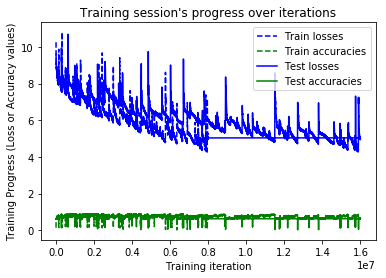

In [18]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)

#width = 12
#height = 12
#plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(config.batch_size, 
    (len(train_losses)+1)*config.batch_size, config.batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(config.batch_size, 
    len(test_losses)*config.display_iter, config.display_iter)[:-1]), 
    [config.training_epochs])

plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

# multi-class confusion matrix and metrics plot

Testing Accuracy: Tensor("mul_7:0", shape=(), dtype=float32)%

Precision: 41.4356820458%
Recall: 42.16%
f1_score: 41.7788714039%

Confusion Matrix:
[[   0    3    3    0    2    3   25    0    0    0    0    0    0]
 [   0  187   82    0  233   92 1119    5    0    0    0   97    0]
 [   0   49   18    0   59   28  337    1    0    0    0   14    0]
 [   0    0    0    0    0    0    1    0    0    0    0    0    0]
 [   0  290  102    0  268  126 1522    0    0    0    0  121    0]
 [   0  112   34    0  119   50  594    4    0    0    0   48    0]
 [   0 1339  565    0 1403  621 7873   11    0    0    0  644    0]
 [   0   53   31    0   54   21  404    0    0    0    0   32    0]
 [   0   33   18    0   58   23  262    0    0    0    0   28    0]
 [   0    1    1    0    5    1   20    0    0    0    0    1    0]
 [   0    3    1    0    3    0   16    0    0    0    0    2    0]
 [   0   63   32    0   83   45  461    1    0    0    0   36    0]
 [   0    1    0    0    0    0    3

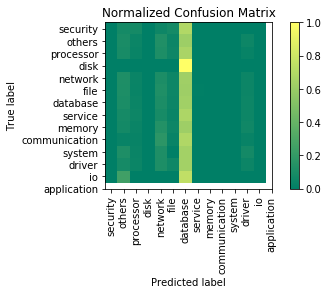

In [30]:
# Results
predictions = test_predictions[730]
for i in range(731,750):
    predictions = np.vstack((predictions, test_predictions[i]))
predictions = predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    y_test, predictions, target_names = list(fault_label.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)